In [67]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras.models import Sequential
import matplotlib.patches as mpatches
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


import os


In [68]:
data = pd.read_csv('testset.csv')

In [69]:
data['datetime_utc'] = pd.to_datetime(data['datetime_utc'])
data.set_index('datetime_utc', inplace= True)
data =data.resample('D').mean()

<ipython-input-69-590352862da9>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data =data.resample('D').mean()


In [70]:
data = data[[' _tempm' ]]

In [71]:
data[' _tempm'] = data[' _tempm'].interpolate()# we will fill the null row

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7480 entries, 1996-11-01 to 2017-04-24
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0    _tempm  7480 non-null   float64
dtypes: float64(1)
memory usage: 116.9 KB


In [74]:
df = data.copy()

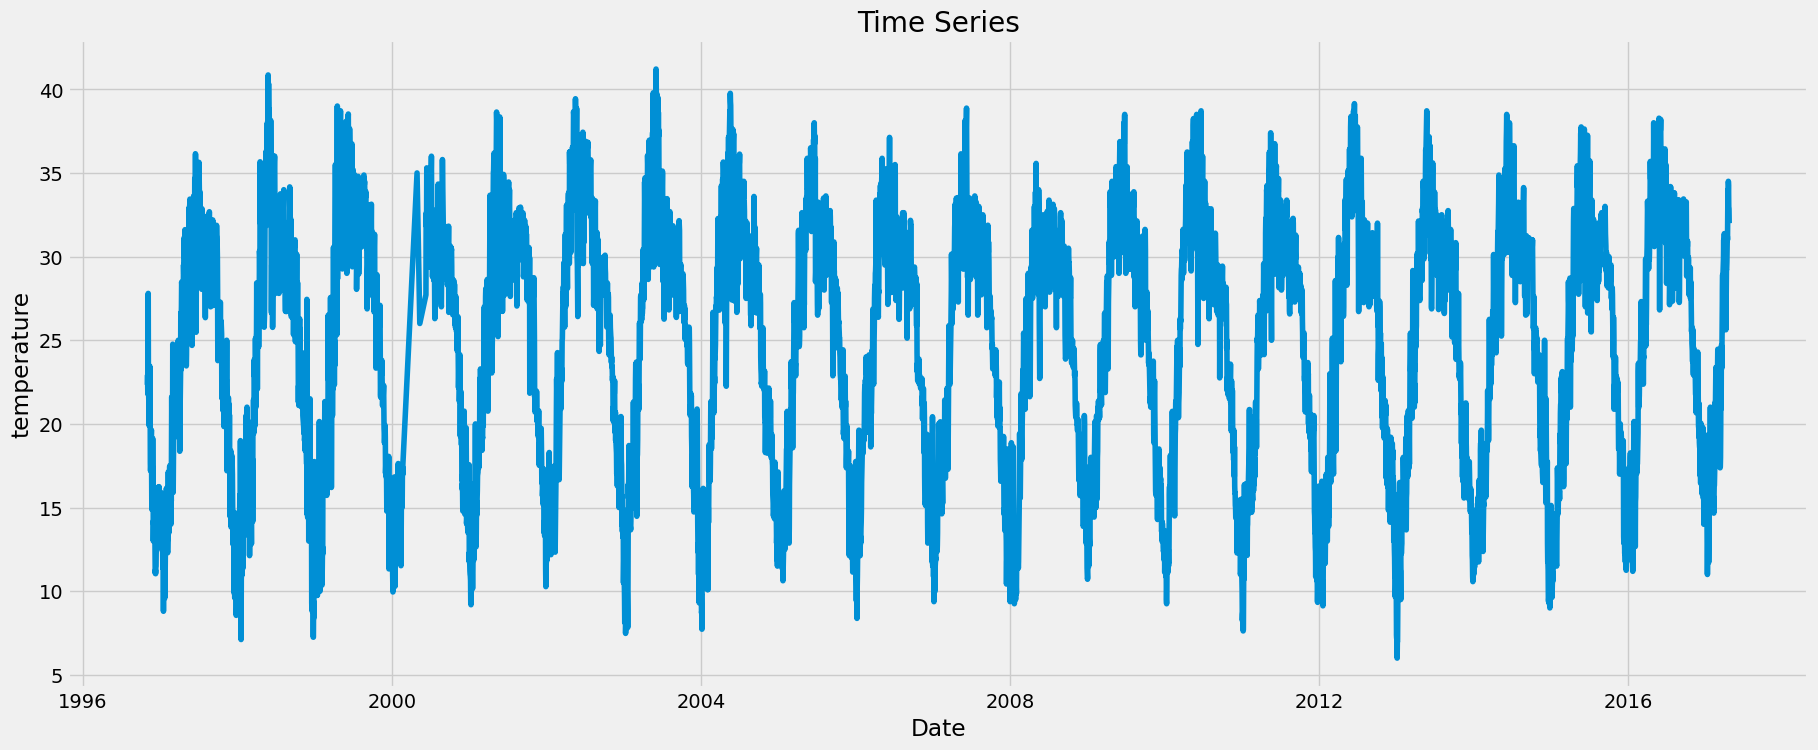

In [75]:
plt.figure(figsize=(20,8))
plt.plot(data)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('temperature')
plt.show()

In [76]:
data=data.values
data = data.astype('float32')

In [77]:
scaler= MinMaxScaler(feature_range=(-1,1))
sc = scaler.fit_transform(data)

In [78]:
timestep = 30

X= []
Y=[]


for i in range(len(sc)- (timestep)):
    X.append(sc[i:i+timestep])
    Y.append(sc[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 7300
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]
Ytrain = Y[:k]
Ytest= Y[k:]

In [79]:
print(Xtrain.shape)
print(Xtest.shape)

(7300, 30, 1)
(150, 30, 1)


In [80]:
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [81]:
model = Sequential()

model.add(LSTM(32,activation = 'relu', input_shape= (30,1), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='sigmoid', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [82]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 32)            4352      
                                                                 
 lstm_7 (LSTM)               (None, 30, 32)            8320      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [83]:
history = model.fit(Xtrain,Ytrain,epochs=50, verbose=1)


Epoch 1/50
229/229 [==============================] - 15s 46ms/step - loss: 0.0414
Epoch 2/50
229/229 [==============================] - 11s 47ms/step - loss: 0.0155
Epoch 3/50
229/229 [==============================] - 9s 41ms/step - loss: 0.0123
Epoch 4/50
229/229 [==============================] - 10s 44ms/step - loss: 0.0101
Epoch 5/50
229/229 [==============================] - 11s 46ms/step - loss: 0.0097
Epoch 6/50
229/229 [==============================] - 11s 49ms/step - loss: 0.0094
Epoch 7/50
229/229 [==============================] - 10s 45ms/step - loss: 0.0093
Epoch 8/50
229/229 [==============================] - 9s 39ms/step - loss: 0.0093
Epoch 9/50
229/229 [==============================] - 10s 45ms/step - loss: 0.0092
Epoch 10/50
229/229 [==============================] - 10s 44ms/step - loss: 0.0092
Epoch 11/50
229/229 [==============================] - 10s 45ms/step - loss: 0.0091
Epoch 12/50
229/229 [==============================] - 9s 39ms/step - loss: 0.0094
Epoc

Text(0.5, 1.0, 'Model Accuracy')

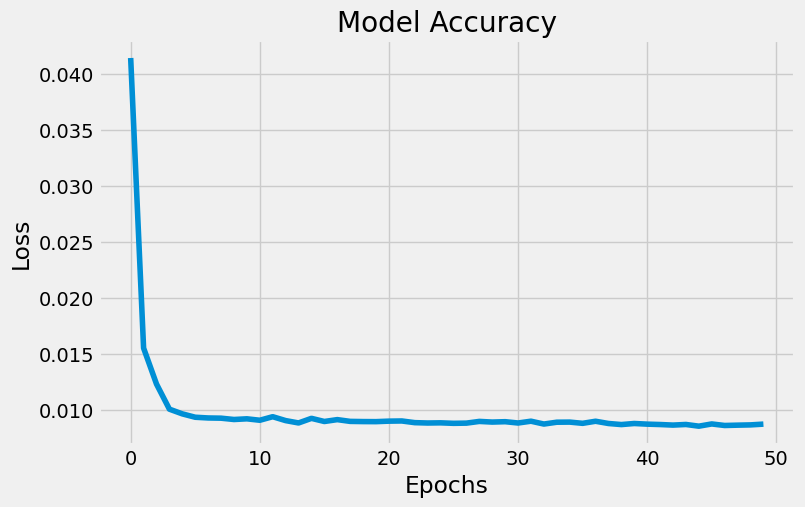

In [84]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

In [85]:
model

In [86]:
preds= model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)
Ytest=Ytest.reshape(-1,1)
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)
Ytrain=Ytrain.reshape(-1,1)
Ytrain = scaler.inverse_transform(Ytrain)

mean_squared_error(Ytest,preds)

5/5 [==============================] - 0s 11ms/step


2.7567096

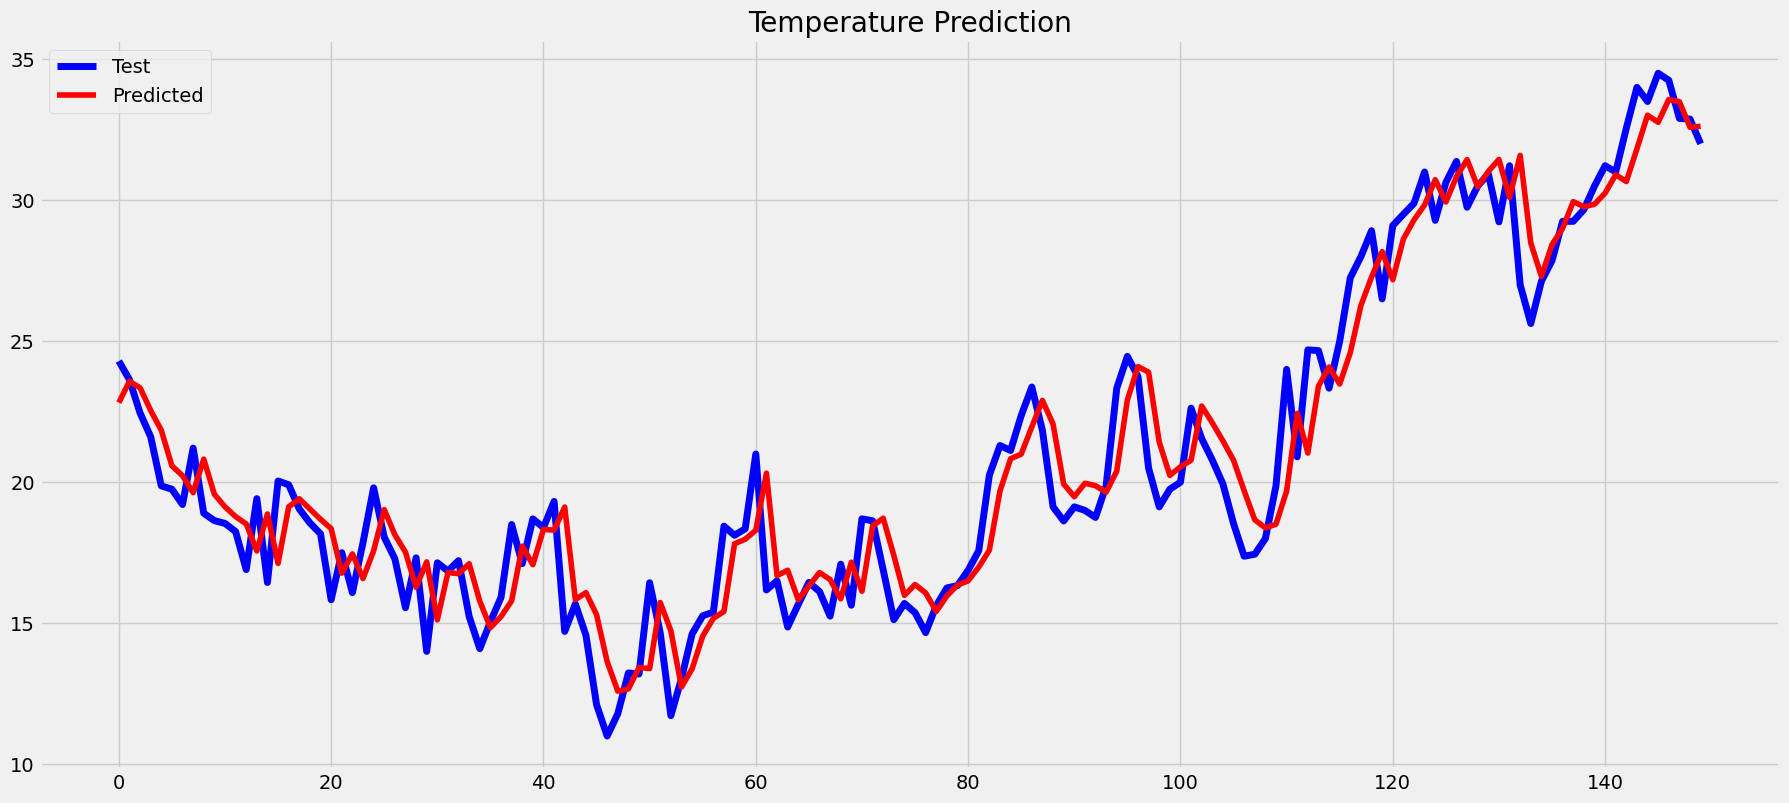

In [87]:
plt.figure(figsize=(20,9))
plt.plot(Ytest , 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Temperature Prediction")
plt.show()

In [88]:
test = pd.DataFrame(Ytest,columns=['Actual'])
pred = pd.DataFrame(preds,columns=['Predict'])
results = pd.concat([test,pred],axis=1)
results.head(20)

,Actual,Predict
0,24.294117,22.820932
1,23.636364,23.578226
2,22.454546,23.347183
3,21.611111,22.543713
4,19.869566,21.841246
5,19.750000,20.581770
6,19.208334,20.229412
7,21.208334,19.630066
8,18.900000,20.817556
9,18.636364,19.570488


In [89]:
def insert_end(Xin,new_input):
    #print ('Before: \n', Xin , new_input )
    for i in range(timestep-1):
        Xin[:,i,:] = Xin[:,i+1,:]
    Xin[:,timestep-1,:] = new_input
    #print ('After :\n', Xin)
    return Xin

In [90]:

df


,_tempm
datetime_utc,
1996-11-01,22.333333
1996-11-02,22.916667
1996-11-03,21.791667
1996-11-04,22.722222
1996-11-05,27.800000
...,...
2017-04-20,34.500000
2017-04-21,34.250000
2017-04-22,32.900000


In [91]:
# this section for unknown future
#we are getting next 30 steps
from datetime import timedelta
future=30
forcast = []
Xin = Xtest[-1:,:,:]
time=[]
for i in range(future):
    out = model.predict(Xin, batch_size=1)
    forcast.append(out[0,0])
    print(forcast)
    Xin = insert_end(Xin,out[0,0])
    time.append(pd.to_datetime(df.index[-1])+timedelta(days=i+1))

1/1 [==============================] - 0s 32ms/step
[0.51209044]
1/1 [==============================] - 0s 30ms/step
[0.51209044, 0.50214267]
1/1 [==============================] - 0s 35ms/step
[0.51209044, 0.50214267, 0.49586993]
1/1 [==============================] - 0s 37ms/step
[0.51209044, 0.50214267, 0.49586993, 0.490385]
1/1 [==============================] - 0s 32ms/step
[0.51209044, 0.50214267, 0.49586993, 0.490385, 0.4856664]
1/1 [==============================] - 0s 27ms/step
[0.51209044, 0.50214267, 0.49586993, 0.490385, 0.4856664, 0.48157915]
1/1 [==============================] - 0s 30ms/step
[0.51209044, 0.50214267, 0.49586993, 0.490385, 0.4856664, 0.48157915, 0.47784132]
1/1 [==============================] - 0s 24ms/step
[0.51209044, 0.50214267, 0.49586993, 0.490385, 0.4856664, 0.48157915, 0.47784132, 0.4743541]
1/1 [==============================] - 0s 39ms/step
[0.51209044, 0.50214267, 0.49586993, 0.490385, 0.4856664, 0.48157915, 0.47784132, 0.4743541, 0.47110596]
1/

In [92]:
forcasted_output=np.asanyarray(forcast)
forcasted_output=forcasted_output.reshape(-1,1)
forcasted_output = scaler.inverse_transform(forcasted_output)

In [93]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output],axis=1)
df_result.columns = "Date","Forecasted"

In [94]:
df.columns
df_result

,Date,Forecasted
0,2017-04-25,32.620750
1,2017-04-26,32.445618
2,2017-04-27,32.335182
3,2017-04-28,32.238621
4,2017-04-29,32.155548
5,2017-04-30,32.083591
6,2017-05-01,32.017788
7,2017-05-02,31.956390
8,2017-05-03,31.899208
9,2017-05-04,31.845078


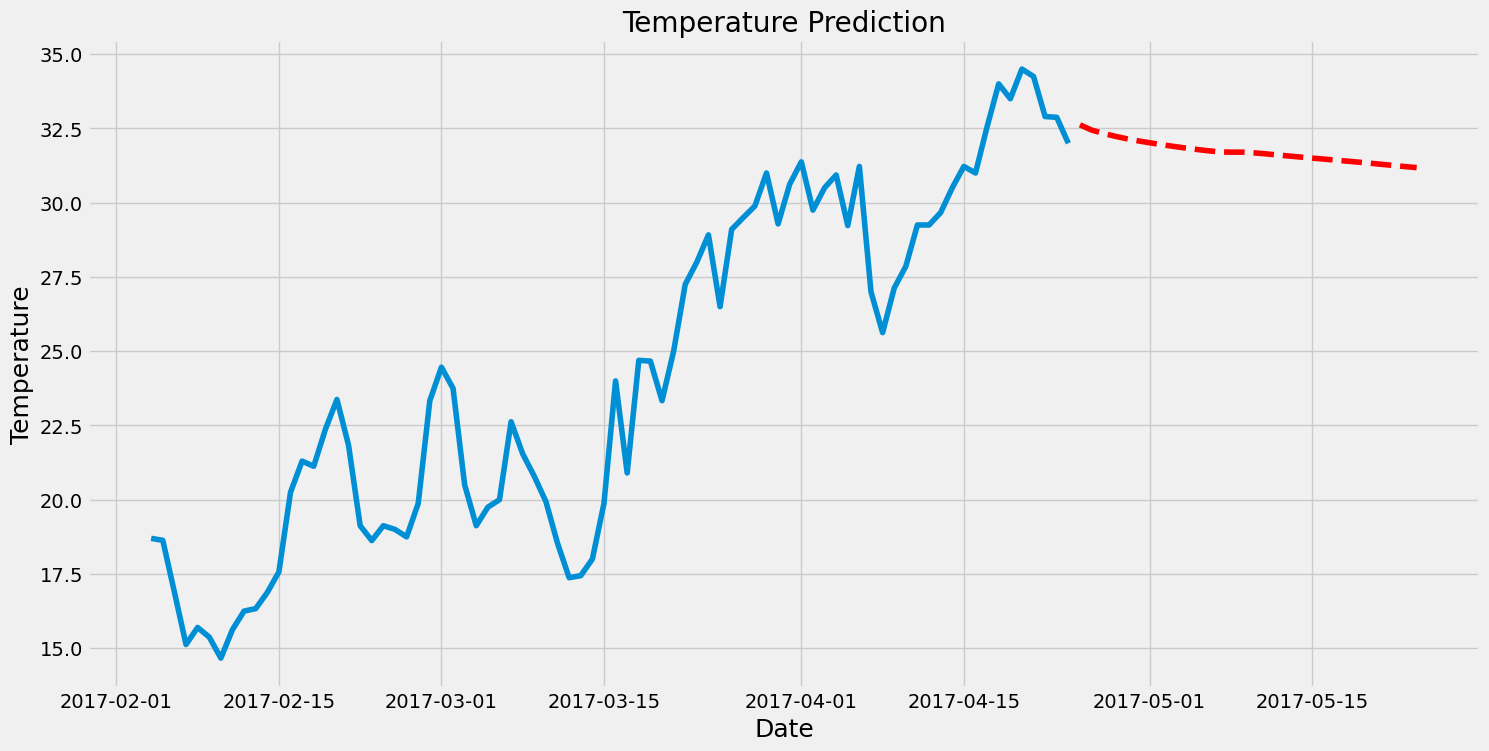

In [95]:
plt.figure(figsize=(16,8))
plt.title('Temperature Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temperature' ,fontsize=18)
plt.plot(df[' _tempm'][7400:])
plt.plot(df_result.set_index('Date')[['Forecasted']],"r--")